In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import pickle
import os
import gc
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import time

from utilities import (
    RANDOM_STATE, TARGET_COL, N_FOLD, FOLD_STRAT_NAME, REDUCED_FOLD_NAME,
    PARAMS_LGB_BASE
)

from train import (
    train_feat_sel, feat_selection_pipeline
)

INPUT_PATH = '../input/tabular-playground-series-oct-2021'
PATH_NOTEBOOK = '../input/preprocess'

In [2]:
train = pd.read_pickle(
    os.path.join(PATH_NOTEBOOK, 'train_unscaled.pkl')
)

In [3]:
with open(os.path.join(PATH_NOTEBOOK, 'feature_dic.pkl'), 'rb') as file:
    feature_dic = pickle.load(file)

# IMPORT DEL CLASS LIST

In [4]:
with open(os.path.join(PATH_NOTEBOOK, 'possible_del_shift.pkl'), 'rb') as file:
    possible_del_class = pickle.load(file)
    
possible_del_class = [x for _, x in possible_del_class[:50]]

In [5]:
#CONSTANT
FEATURE = feature_dic['feature']
CAT_COL = feature_dic['categorical']
NUMERIC_COL = feature_dic['numerical']

FOLD_LIST = list(range(N_FOLD))

gc.collect()

42

# FEATURE SELECTION PHASE
Iterate over POSSIBLE_DEL_* list and take out 1 feature at time

In [6]:
%%time
del_list = feat_selection_pipeline(data = train, feature_list = FEATURE, possible_del_list = possible_del_class,  
                            params = PARAMS_LGB_BASE, cat_col = CAT_COL, target_name = TARGET_COL, 
                            fold_strat_name = REDUCED_FOLD_NAME, new_learning_rate = .05, 
                            verbose_eval = -1, early_stopping_rounds = 30)

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[177]	validation's auc: 0.845205
Base score: 0.845205



Minute one iteration: 2.1; All iteration: 103.3



Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[263]	validation's auc: 0.845476


Feature f244 dropped. Delta AUC: 0.000272


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[287]	validation's auc: 0.845359
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[202]	validation's auc: 0.845996


Feature f251 dropped. Delta AUC: 0.000520


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[218]	validation's auc: 0.844945
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[254]	validation's auc: 0.846082


Feature f152 dropped. Delta AUC: 0.000086


Training unti

# TRAIN

In [7]:
del_list

['f244', 'f251', 'f152', 'f130', 'f114']

In [8]:
FEATURE = [x for x in FEATURE if x not in del_list]
CAT_COL = [x for x in CAT_COL if x not in del_list]
NUMERIC_COL = [x for x in NUMERIC_COL if x not in del_list]

feature_dic = {
    'feature': FEATURE,
    'categorical': CAT_COL,
    'numerical': NUMERIC_COL,
}

In [9]:
score = 0
model_list = []

for i, fold_ in enumerate(FOLD_LIST):

    mask_train = (train[FOLD_STRAT_NAME] != fold_)
    mask_test = (train[FOLD_STRAT_NAME] == fold_)
    
    
    train_x, train_y = train.loc[mask_train, FEATURE], train.loc[mask_train, TARGET_COL]
    test_x, test_y = train.loc[mask_test, FEATURE], train.loc[mask_test, TARGET_COL]

    model = lgb.train(
        PARAMS_LGB_BASE,
        lgb.Dataset(train_x, label=train_y,categorical_feature=CAT_COL), 100000,
        valid_sets = lgb.Dataset(test_x, label=test_y,categorical_feature=CAT_COL),
        valid_names ='validation', verbose_eval=20, early_stopping_rounds = 30,
    )
    
    #evaluate score and save model for importance/prediction
    score_fold = model.best_score['validation']['auc'] 
    score += score_fold/N_FOLD
    
    model_list.append(model)
    
    print('\nFold: {}; Auc: {:.5f}\n'.format(fold_, score_fold))
    print('-'*50)
    print('\n\n\n')
    gc.collect()
    
print('CV-Auc: {:.5f}\n'.format(score))

Training until validation scores don't improve for 30 rounds
[20]	validation's auc: 0.839549
[40]	validation's auc: 0.842258
[60]	validation's auc: 0.844474
[80]	validation's auc: 0.846381
[100]	validation's auc: 0.847842
[120]	validation's auc: 0.849322
[140]	validation's auc: 0.850532
[160]	validation's auc: 0.851376
[180]	validation's auc: 0.852023
[200]	validation's auc: 0.852598
[220]	validation's auc: 0.853008
[240]	validation's auc: 0.853335
[260]	validation's auc: 0.85358
[280]	validation's auc: 0.853711
[300]	validation's auc: 0.853868
[320]	validation's auc: 0.853953
[340]	validation's auc: 0.854047
[360]	validation's auc: 0.854129
[380]	validation's auc: 0.854197
[400]	validation's auc: 0.854254
[420]	validation's auc: 0.854206
Early stopping, best iteration is:
[396]	validation's auc: 0.854269

Fold: 0; Auc: 0.85427

--------------------------------------------------




Training until validation scores don't improve for 30 rounds
[20]	validation's auc: 0.838733
[40]	valida

# Feature importance

In [10]:
feature_importances = pd.DataFrame()
feature_importances['feature'] = FEATURE


for fold_, model in enumerate(model_list):
    feature_importances['fold_{}'.format(fold_ + 1)] = model.feature_importance(importance_type='gain')

Text(0.5, 1.0, '50 TOP feature importance over 5 average')

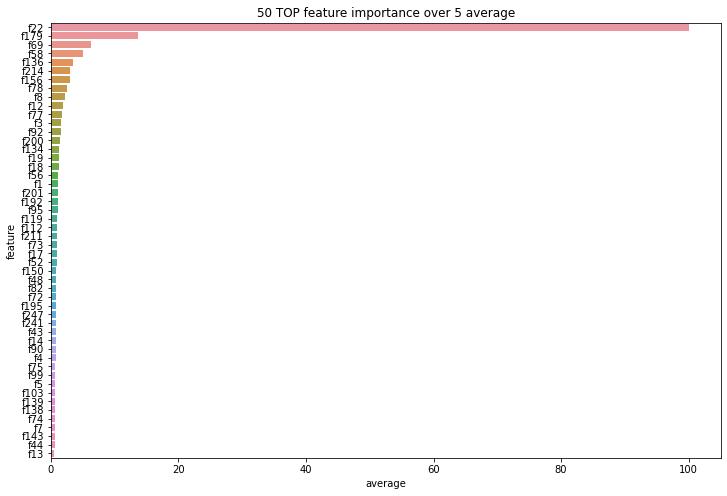

In [11]:
scaler = MinMaxScaler(feature_range=(0, 100))

average_importance = feature_importances.drop('feature', axis = 1).mean(axis=1)

feature_importances['average'] = scaler.fit_transform(X=pd.DataFrame(average_importance))
feature_importances = feature_importances.sort_values(by='average', ascending=False)

feature_importances[['feature', 'average']].to_csv('feature_importances.csv',index=False)

fig = plt.figure(figsize=(12,8))
sns.barplot(data=feature_importances.head(50), x='average', y='feature');
plt.title(f'50 TOP feature importance over {N_FOLD} average')

# TEST Blending

In [12]:
del train
gc.collect()

36

In [13]:
test = pd.read_pickle(
    os.path.join(PATH_NOTEBOOK, 'test_unscaled.pkl')
)

In [14]:
pred_test = np.zeros(test.shape[0])

for fold_, model in enumerate(model_list):
    pred_test += model.predict(test[FEATURE])/N_FOLD


# SAVE RESULT

In [15]:
#FINDED NEW FEATURE
with open('feature_dic.pkl', 'wb') as file_name:
    pickle.dump(feature_dic, file_name)

In [16]:
submission = pd.read_csv(os.path.join(INPUT_PATH, 'sample_submission.csv'))
submission['target'] = pred_test

submission.to_csv('submission.csv', index = False)